In [1]:
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
import shutil
import seaborn as sns
from cv2 import resize
from tqdm import tqdm
import PIL
from PIL import Image
from pathlib import Path
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras
from keras.utils import plot_model
!pip install visualkeras
import visualkeras
from sklearn.metrics import f1_score
import numpy as np
import sklearn
from sklearn.model_selection import train_test_split
# The ImageDataGenerator class is now located in tensorflow.keras.preprocessing.image
from tensorflow.keras.preprocessing.image import ImageDataGenerator

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 993.7/993.7 kB 18.4 MB/s eta 0:00:00


In [2]:
import kagglehub

path = kagglehub.dataset_download("sharko294/image-dataset-for-car-damage-classification")

print("Path to dataset files:", path)

100%|██████████| 912M/912M [00:14<00:00, 65.2MB/s]

Extracting files...


Path to dataset files: /root/.cache/kagglehub/datasets/sharko294/image-dataset-for-car-damage-classification/versions/1


In [3]:
!nvidia-smi

Sun Nov 17 05:51:53 2024       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 535.104.05             Driver Version: 535.104.05   CUDA Version: 12.2     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  Tesla T4                       Off | 00000000:00:04.0 Off |                    0 |
| N/A   50C    P8              10W /  70W |      0MiB / 15360MiB |      0%      Default |
|                                         |                      |                  N/A |
+-----------------------------------------+----------------------+--

In [4]:
device_name = tf.test.gpu_device_name()
if len(device_name) > 0:
    print("Found GPU at: {}".format(device_name))
else:
    device_name = "/device:CPU:0"
    print("No GPU, using {}.".format(device_name))

Found GPU at: /device:GPU:0


In [5]:
strategy = tf.distribute.MirroredStrategy()
print('Number of devices: {}'.format(strategy.num_replicas_in_sync))

Number of devices: 1


In [6]:
csv=pd.read_csv('/root/.cache/kagglehub/datasets/sharko294/image-dataset-for-car-damage-classification/versions/1/train/train.csv')
X_train, X_test, y_train, y_test = train_test_split(csv.iloc[:,:-1], csv.iloc[:,-1], test_size=0.33, random_state=42)

#seperating test & train data to diff dir
csv_train=pd.concat([X_train,y_train],axis=1)
csv_test=pd.concat([X_test,y_test],axis=1)

os.makedirs('/kaggle/working/train_ds', exist_ok=True)  # Use os.makedirs for nested directories
os.makedirs('/kaggle/working/test_ds', exist_ok=True)
for l in list(csv_train.label.unique()):
    os.makedirs('/kaggle/working/train_ds/' + str(l), exist_ok=True)
os.makedirs('/kaggle/working/test_ds/images', exist_ok=True)


In [7]:
csv_train.to_csv('/kaggle/working/train_ds/train.csv',index=False)
csv_test.to_csv('/kaggle/working/test_ds/test.csv',index=False)

In [8]:
for row in tqdm(csv_train.itertuples()):
    im='/root/.cache/kagglehub/datasets/sharko294/image-dataset-for-car-damage-classification/versions/1/train/images/'+row.filename
    des='/kaggle/working/train_ds/'+str(row.label)
    if os.path.exists(des+'\\'+row.filename):
        pass
    else:
        try:
            shutil.move(im,des)
        except:
            pass

4824it [00:00, 17744.71it/s]


In [9]:
for row in tqdm(csv_test.itertuples()):
    im='/root/.cache/kagglehub/datasets/sharko294/image-dataset-for-car-damage-classification/versions/1/train/images/'+row.filename
    des='/kaggle/working/test_ds/images/'
    try:
        shutil.move(im,des)
    except:
        pass

2376it [00:00, 25663.34it/s]


In [10]:
for i in range(1,7):
    print(f"{i}----->{len(os.listdir('/kaggle/working/train_ds/'+str(i)))}")

print(len(os.listdir('/kaggle/working/test_ds/images')))
del csv, X_train, X_test, y_train, y_test, csv_test, csv_train

1----->116
2----->1567
3----->357
4----->1409
5----->795
6----->580
2376


In [11]:
sample_len=1600
img_dir='/kaggle/working/train_ds/'

#creating keras image data generator object
datagen=ImageDataGenerator(zoom_range=[0.5,1.5],
                           vertical_flip=True,
                           horizontal_flip=True,
                           rotation_range=20,
                              fill_mode='constant')

In [12]:
for dirc in os.listdir(img_dir):
    dirc=os.path.join(img_dir,dirc)
    if os.path.isdir(dirc):
        if len(os.listdir(dirc))<sample_len:
            aug_per_img=3
            aug_len=sample_len-len(os.listdir(dirc))
            sample_size=aug_len//aug_per_img
            if sample_size>len(os.listdir(dirc)):
                for i in range(aug_per_img,20,2):
                    if aug_len//i<=len(os.listdir(dirc)):
                        aug_per_img=i
                        sample_size=aug_len//aug_per_img
                        break
            print(f'{dirc}---> aug_len: {aug_len}, sample_len: {sample_size}')
            for img_sample in tqdm(np.random.choice([os.path.join(dirc,img_path) for img_path in os.listdir(dirc)],
                                        sample_size,replace=False)):
                image=keras.utils.load_img(img_sample)
                array = tf.keras.utils.img_to_array(image)
                count=1
                file_name=img_sample.split('.')[0]
                for batch in datagen.flow(array.reshape((1,)+array.shape),
                                          batch_size=1,seed=29):
                    keras.utils.save_img(file_name+'_aug'+str(count)+'.jpg',
                                         x=batch.reshape(array.shape),scale=True)
                    count+=1
                    if count>aug_per_img:
                        break


/kaggle/working/train_ds/4---> aug_len: 191, sample_len: 63


100%|██████████| 63/63 [00:38<00:00,  1.62it/s]


/kaggle/working/train_ds/3---> aug_len: 1243, sample_len: 248


100%|██████████| 248/248 [03:58<00:00,  1.04it/s]


/kaggle/working/train_ds/6---> aug_len: 1020, sample_len: 340


100%|██████████| 340/340 [02:55<00:00,  1.93it/s]


/kaggle/working/train_ds/1---> aug_len: 1484, sample_len: 114


100%|██████████| 114/114 [04:30<00:00,  2.37s/it]


/kaggle/working/train_ds/2---> aug_len: 33, sample_len: 11


100%|██████████| 11/11 [00:07<00:00,  1.44it/s]


/kaggle/working/train_ds/5---> aug_len: 805, sample_len: 268


100%|██████████| 268/268 [02:23<00:00,  1.87it/s]


In [13]:
for i in range(1,7):
    print(f"{i}----->{len(os.listdir('/kaggle/working/train_ds/'+str(i)))}")

1----->1598
2----->1600
3----->1597
4----->1598
5----->1599
6----->1600


In [14]:
img_height, img_width=224,224
data_dir='/kaggle/working/train_ds'
batch_size=32
train_ds = tf.keras.utils.image_dataset_from_directory(
    label_mode='int',
    directory=data_dir,
    validation_split=0.2,
    subset="training",
    seed=123,
    image_size=(img_height, img_width),
    batch_size=batch_size)
val_ds = tf.keras.utils.image_dataset_from_directory(
    label_mode='int',
    directory=data_dir,
    validation_split=0.2,
    subset="validation",
    seed=123,
    image_size=(img_height, img_width),
    batch_size=batch_size)

Found 9592 files belonging to 6 classes.
Using 7674 files for training.
Found 9592 files belonging to 6 classes.
Using 1918 files for validation.


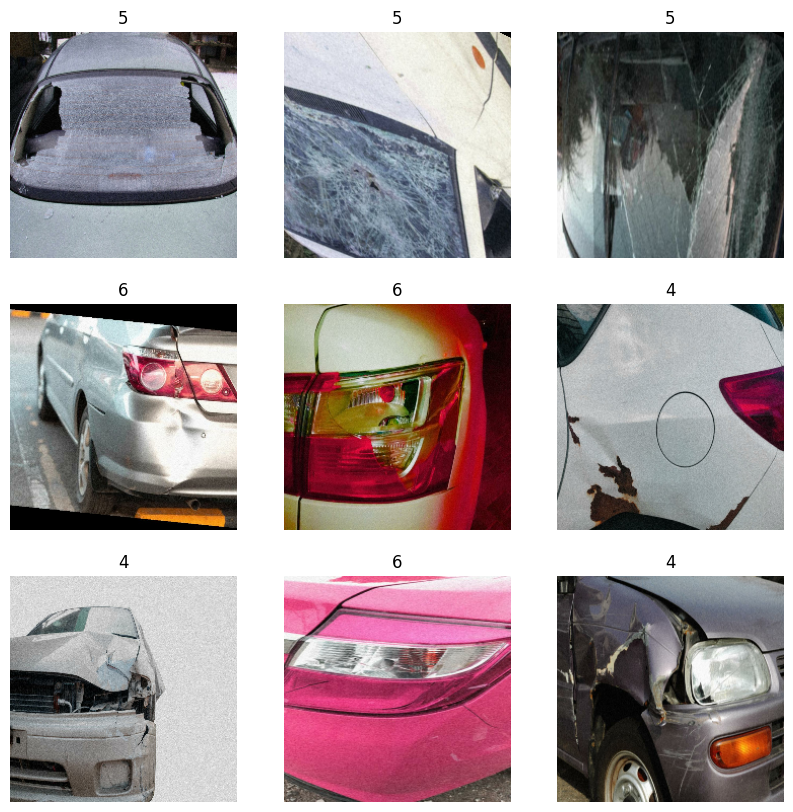

In [15]:
class_names = val_ds.class_names

plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        plt.title(class_names[labels[i]])
        plt.axis("off")

In [16]:
'with strategy.scope():'
with tf.device(device_name):
    base_model=tf.keras.applications.VGG16(include_top=False,
                                       weights='imagenet',
                                       input_shape=(img_height, img_width,3))
    base_model.trainable=False
base_model.summary()

58889256/58889256 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


Model: "vgg16"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)             │ (None, 224, 224, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block1_conv1 (Conv2D)                │ (None, 224, 224, 64)        │           1,792 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block1_conv2 (Conv2D)                │ (None, 224, 224, 64)        │          36,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block1_pool (MaxPooling2D)           │ (None, 112, 112, 64)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block2_conv1 (Conv2D)                │ (None, 112, 112, 128)       │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block2_conv2 (Conv2D)                │ (None, 112, 112, 128)       │         147,584 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block2_pool (MaxPooling2D)           │ (None, 56, 56, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_conv1 (Conv2D)                │ (None, 56, 56, 256)         │         295,168 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_conv2 (Conv2D)                │ (None, 56, 56, 256)         │         590,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_conv3 (Conv2D)                │ (None, 56, 56, 256)         │         590,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_pool (MaxPooling2D)           │ (None, 28, 28, 256)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_conv1 (Conv2D)                │ (None, 28, 28, 512)         │       1,180,160 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_conv2 (Conv2D)                │ (None, 28, 28, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_conv3 (Conv2D)                │ (None, 28, 28, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_pool (MaxPooling2D)           │ (None, 14, 14, 512)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_conv1 (Conv2D)                │ (None, 14, 14, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_conv2 (Conv2D)                │ (None, 14, 14, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_conv3 (Conv2D)                │ (None, 14, 14, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_pool (MaxPooling2D)           │ (None, 7, 7, 512)           │               0 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 14,714,688 (56.13 MB)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 14,714,688 (56.13 MB)

In [17]:
#VGG16 as feature extractor converts each (224,224,3) into (7,7,512) block of feature

image_batch, label_batch = next(iter(train_ds))
print(base_model(image_batch).shape)

(32, 7, 7, 512)


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer_1             │ (None, 224, 224, 3)    │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ get_item (GetItem)        │ (None, 224, 224)       │              0 │ input_layer_1[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ get_item_1 (GetItem)      │ (None, 224, 224)       │              0 │ input_layer_1[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ get_item_2 (GetItem)      │ (None, 224, 224)       │              0 │ input_layer_1[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ stack (Stack)             │ (None, 224, 224, 3)    │              0 │ get_item[0][0],        │
│                           │                        │                │ get_item_1[0][0],      │
│                           │                        │                │ get_item_2[0][0]       │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ add (Add)                 │ (None, 224, 224, 3)    │              0 │ stack[0][0]            │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ vgg16 (Functional)        │ (None, 7, 7, 512)      │     14,714,688 │ add[0][0]              │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ global_average_pooling2d  │ (None, 512)            │              0 │ vgg16[0][0]            │
│ (GlobalAveragePooling2D)  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dropout (Dropout)         │ (None, 512)            │              0 │ global_average_poolin… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense (Dense)             │ (None, 6)              │          3,078 │ dropout[0][0]          │
└───────────────────────────┴────────────────────────┴────────────────┴────────────────────────┘

 Total params: 14,717,766 (56.14 MB)

 Trainable params: 3,078 (12.02 KB)

 Non-trainable params: 14,714,688 (56.13 MB)

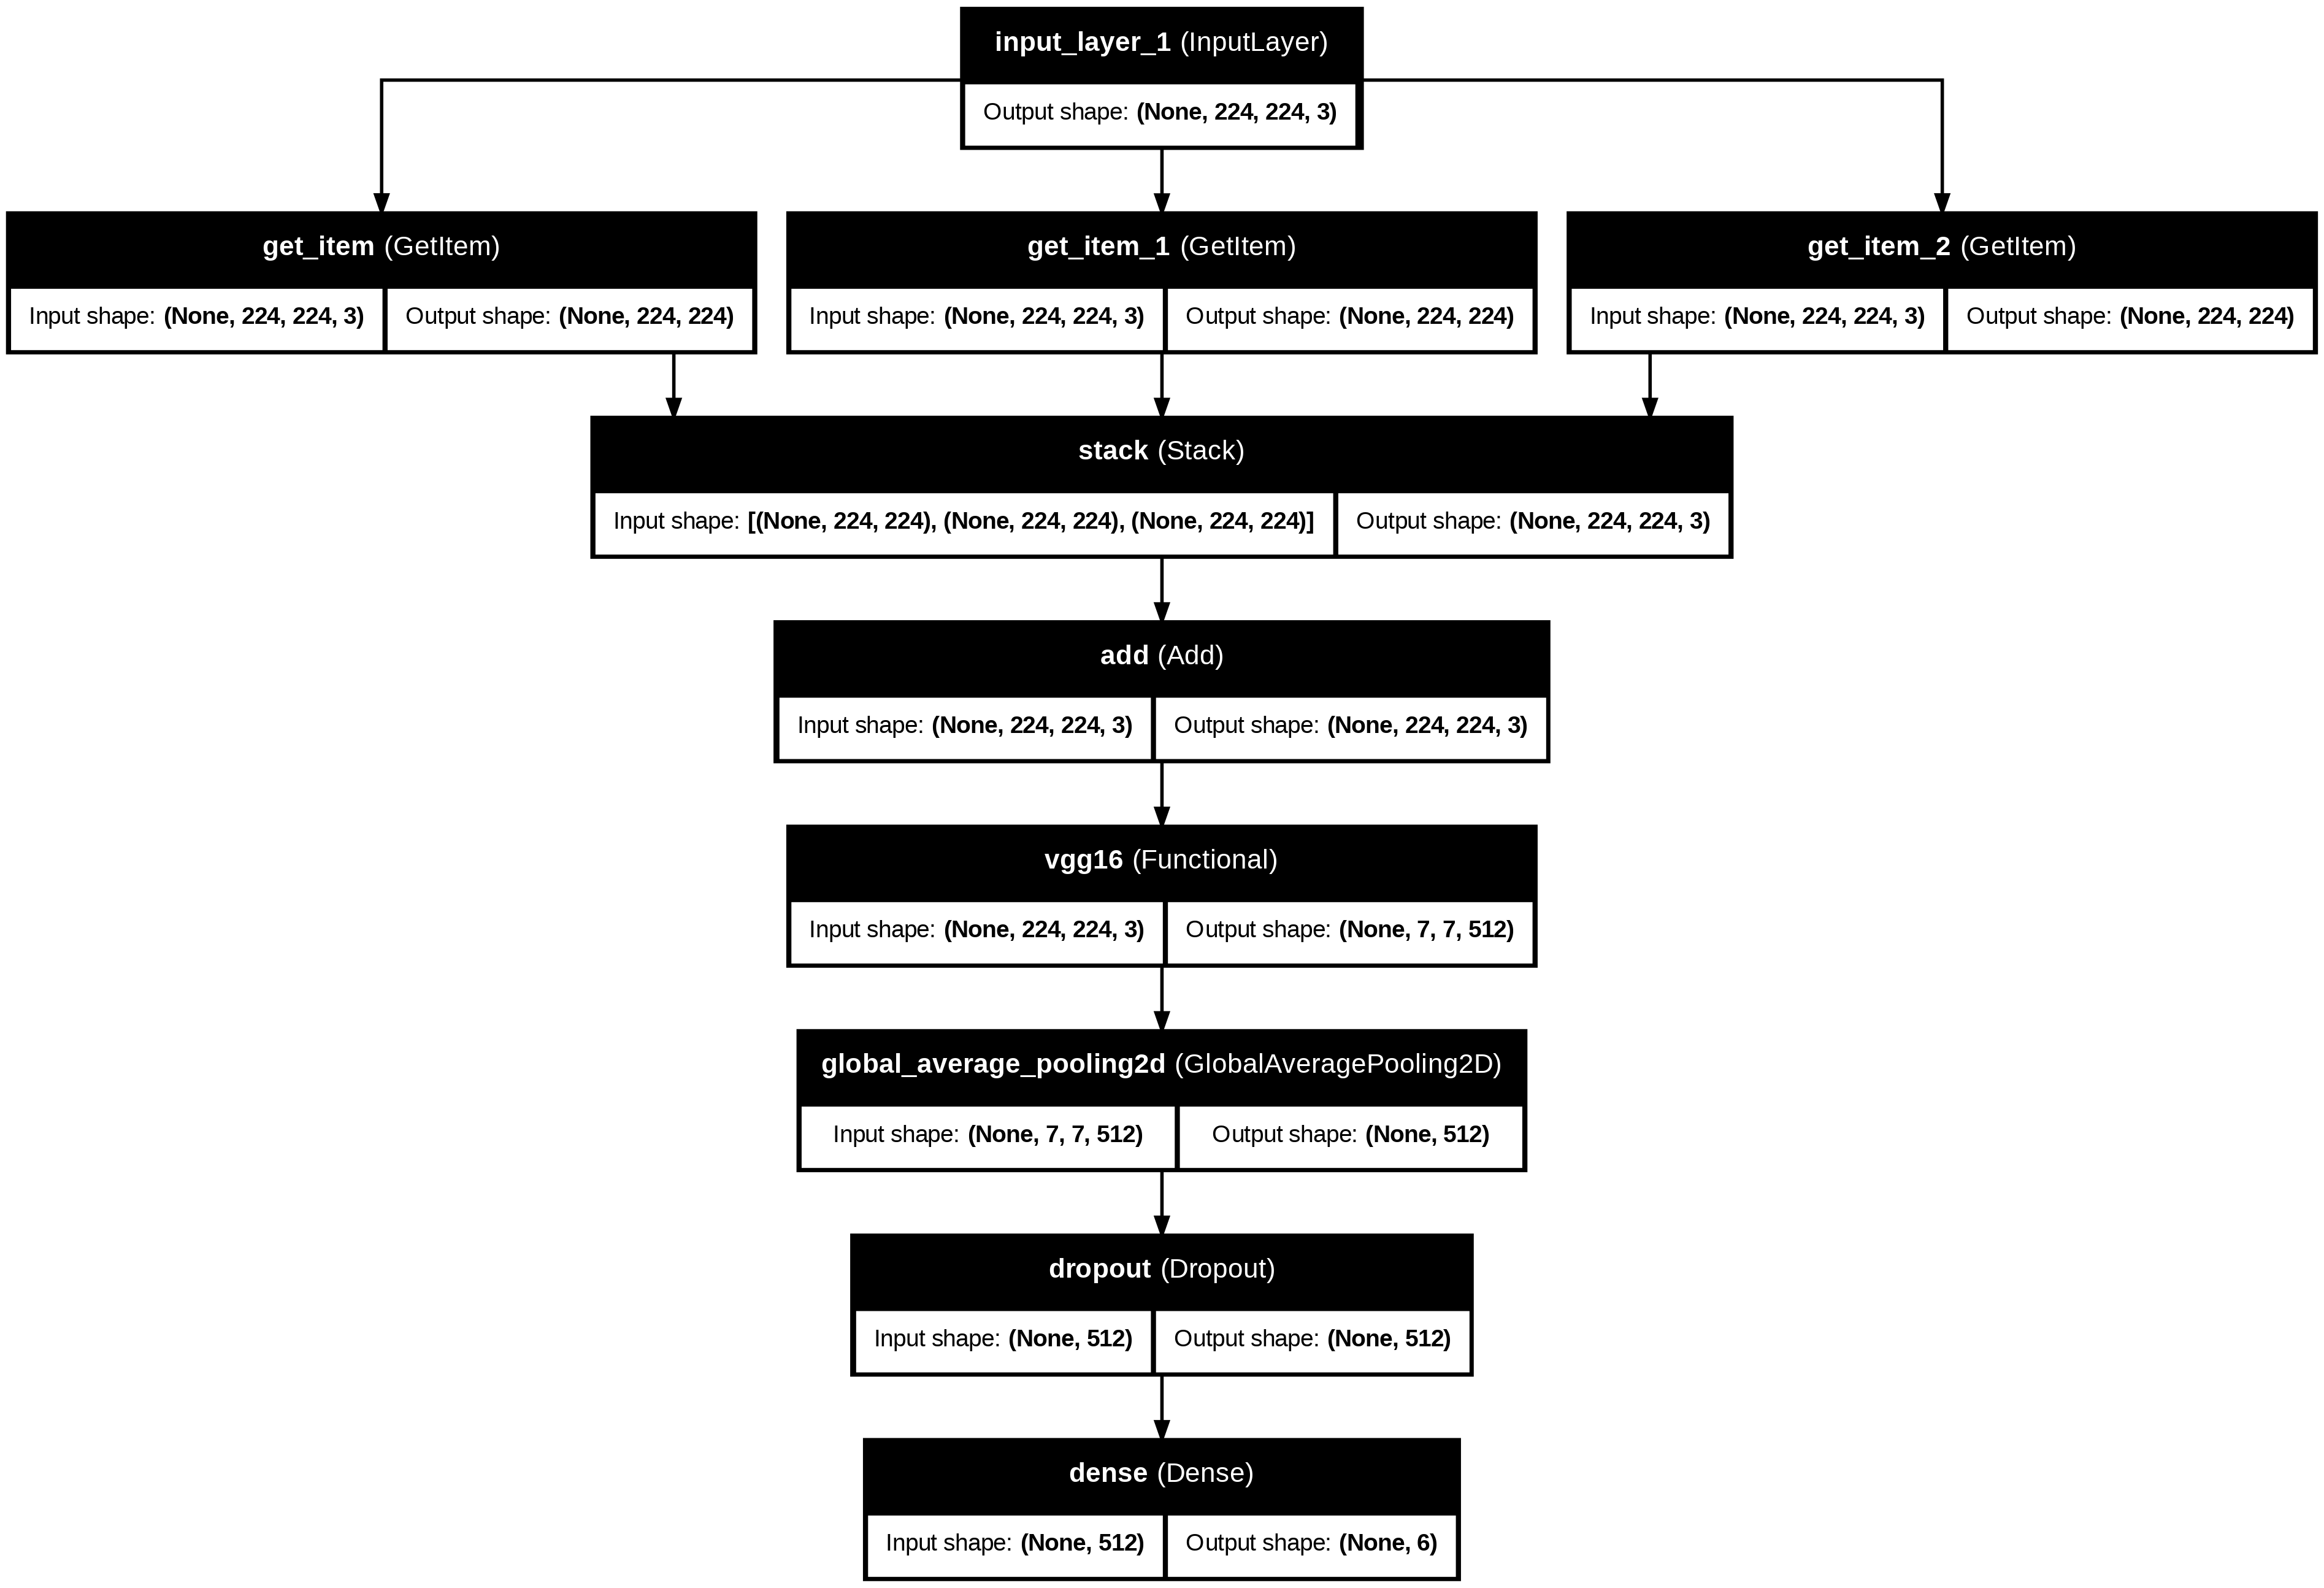

In [18]:
with tf.device(device_name):
    inputs=tf.keras.Input(shape=(img_height, img_width,3))
    x=tf.keras.applications.vgg16.preprocess_input(inputs)
    x=base_model(x,training=False)
    x=tf.keras.layers.GlobalAveragePooling2D()(x)
    x=tf.keras.layers.Dropout(0.6)(x)
    outputs=tf.keras.layers.Dense(6,activation='softmax')(x)
    model=tf.keras.Model(inputs,outputs)
model.summary()
plot_model(model,show_shapes=True,show_layer_names=True)

/usr/local/lib/python3.10/dist-packages/visualkeras/layered.py:86: UserWarning: The legend_text_spacing_offset parameter is deprecated and will be removed in a future release.
  warnings.warn("The legend_text_spacing_offset parameter is deprecated and will be removed in a future release.")


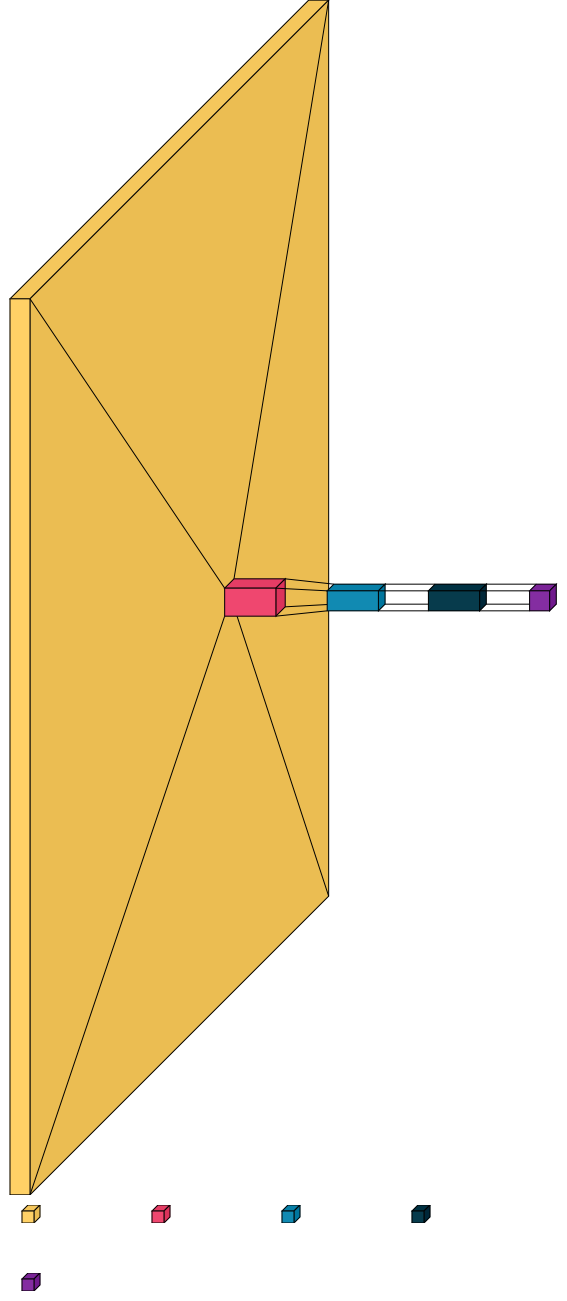

In [19]:
visualkeras.layered_view(model,legend=True,spacing=50,background_fill='white' )

In [20]:
# Define a function to calculate macro F1-score
def macro_f1_score(y_true, y_pred):
    # Convert probabilities to class predictions
    y_pred = np.argmax(y_pred, axis=1)

    # Calculate F1-score for each class
    f1 = f1_score(y_true, y_pred, average='macro')
    return f1

# Create a wrapper function to use the custom metric in Keras
def macro_f1_metric(y_true, y_pred):
    return tf.py_function(macro_f1_score, (y_true, y_pred), tf.float32)

In [21]:
with tf.device(device_name):
    model.compile(optimizer=tf.keras.optimizers.Adam(0.001),
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
              metrics=['accuracy'])

In [22]:
hist=model.fit(train_ds,validation_data=val_ds,epochs=7,
          callbacks=[tf.keras.callbacks.EarlyStopping(monitor='val_loss',
                                                      min_delta=1e-2,
                                                      patience=3,
                                                       verbose=1,
                                                      restore_best_weights=True
                                                      )])

Epoch 1/7
240/240 ━━━━━━━━━━━━━━━━━━━━ 84s 290ms/step - accuracy: 0.3050 - loss: 7.8702 - val_accuracy: 0.6689 - val_loss: 1.3076
Epoch 2/7
240/240 ━━━━━━━━━━━━━━━━━━━━ 46s 192ms/step - accuracy: 0.5393 - loss: 2.9539 - val_accuracy: 0.7404 - val_loss: 0.8942
Epoch 3/7
240/240 ━━━━━━━━━━━━━━━━━━━━ 100s 269ms/step - accuracy: 0.6108 - loss: 1.8669 - val_accuracy: 0.7477 - val_loss: 0.7489
Epoch 4/7
240/240 ━━━━━━━━━━━━━━━━━━━━ 71s 222ms/step - accuracy: 0.6424 - loss: 1.3405 - val_accuracy: 0.7544 - val_loss: 0.7101
Epoch 5/7
240/240 ━━━━━━━━━━━━━━━━━━━━ 75s 193ms/step - accuracy: 0.6530 - loss: 1.1628 - val_accuracy: 0.7633 - val_loss: 0.6652
Epoch 6/7
240/240 ━━━━━━━━━━━━━━━━━━━━ 81s 190ms/step - accuracy: 0.6656 - loss: 1.0800 - val_accuracy: 0.7367 - val_loss: 0.7179
Epoch 7/7
240/240 ━━━━━━━━━━━━━━━━━━━━ 93s 235ms/step - accuracy: 0.6591 - loss: 1.0589 - val_accuracy: 0.7643 - val_loss: 0.6448
Restoring model weights from the end of the best epoch: 7.


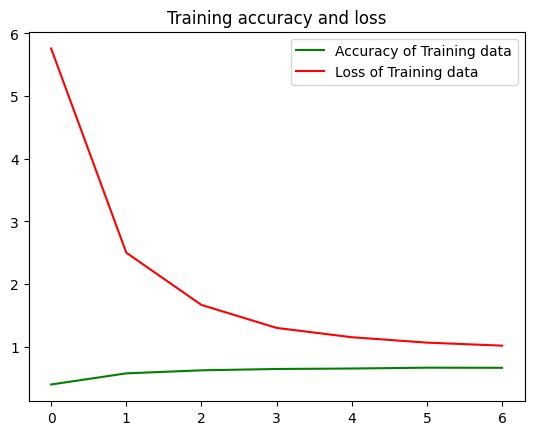

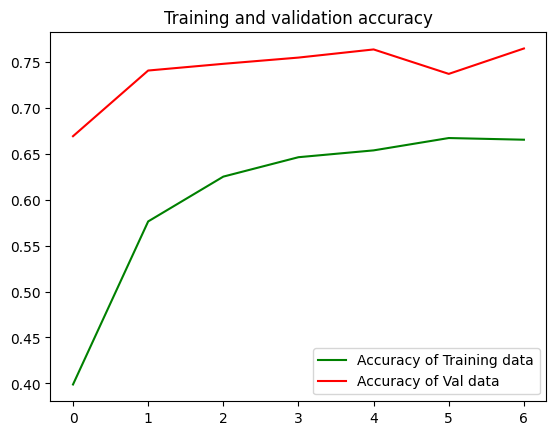

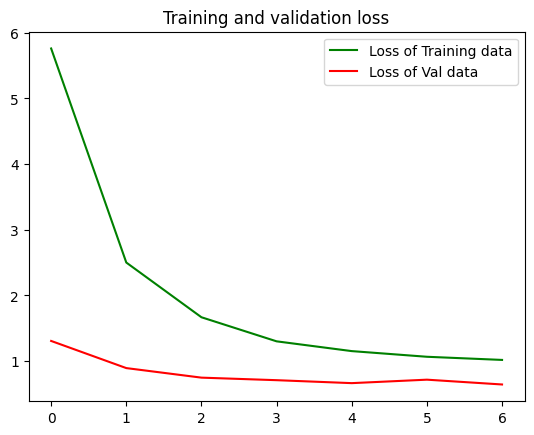

<Figure size 640x480 with 0 Axes>

In [23]:
#plotting graphs from training_1

get_ac=hist.history['accuracy']
get_los=hist.history['loss']
val_acc=hist.history['val_accuracy']
val_loss=hist.history['val_loss']

epochs=range(len(get_ac))
plt.plot(epochs,get_ac,'g',label='Accuracy of Training data')
plt.plot(epochs,get_los,'r',label='Loss of Training data')
plt.title('Training accuracy and loss')
plt.legend(loc=0)
plt.figure()

plt.plot(epochs,get_ac,'g',label='Accuracy of Training data')
plt.plot(epochs,val_acc,'r',label='Accuracy of Val data')
plt.title('Training and validation accuracy')
plt.legend(loc=0)
plt.figure()

epochs=range(len(get_ac))
plt.plot(epochs,get_los,'g',label='Loss of Training data')
plt.plot(epochs,val_loss,'r',label='Loss of Val data')
plt.title('Training and validation loss')
plt.legend(loc=0)
plt.figure()
plt.show()

In [24]:
# Finetuning the model further by unfreezing layers after 14th layer
# as initial layers extract general features and as we approach topmost layers
# our job specific features are extracted and thus the weights at topmost layers are
# adjusted according to our problem, so we'll retrain these top weights for our use.

with tf.device(device_name):
    base_model.trainable=True
    for layer in base_model.layers[:14]:
        layer.trainable=False
base_model.summary()

Model: "vgg16"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)             │ (None, 224, 224, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block1_conv1 (Conv2D)                │ (None, 224, 224, 64)        │           1,792 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block1_conv2 (Conv2D)                │ (None, 224, 224, 64)        │          36,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block1_pool (MaxPooling2D)           │ (None, 112, 112, 64)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block2_conv1 (Conv2D)                │ (None, 112, 112, 128)       │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block2_conv2 (Conv2D)                │ (None, 112, 112, 128)       │         147,584 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block2_pool (MaxPooling2D)           │ (None, 56, 56, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_conv1 (Conv2D)                │ (None, 56, 56, 256)         │         295,168 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_conv2 (Conv2D)                │ (None, 56, 56, 256)         │         590,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_conv3 (Conv2D)                │ (None, 56, 56, 256)         │         590,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_pool (MaxPooling2D)           │ (None, 28, 28, 256)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_conv1 (Conv2D)                │ (None, 28, 28, 512)         │       1,180,160 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_conv2 (Conv2D)                │ (None, 28, 28, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_conv3 (Conv2D)                │ (None, 28, 28, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_pool (MaxPooling2D)           │ (None, 14, 14, 512)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_conv1 (Conv2D)                │ (None, 14, 14, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_conv2 (Conv2D)                │ (None, 14, 14, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_conv3 (Conv2D)                │ (None, 14, 14, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_pool (MaxPooling2D)           │ (None, 7, 7, 512)           │               0 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 14,714,688 (56.13 MB)

 Trainable params: 7,079,424 (27.01 MB)

 Non-trainable params: 7,635,264 (29.13 MB)

In [25]:
# Compiling the model
with tf.device(device_name):
    model.compile(optimizer=tf.keras.optimizers.Adam(0.00001),
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
              metrics=['accuracy'])
model.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer_1             │ (None, 224, 224, 3)    │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ get_item (GetItem)        │ (None, 224, 224)       │              0 │ input_layer_1[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ get_item_1 (GetItem)      │ (None, 224, 224)       │              0 │ input_layer_1[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ get_item_2 (GetItem)      │ (None, 224, 224)       │              0 │ input_layer_1[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ stack (Stack)             │ (None, 224, 224, 3)    │              0 │ get_item[0][0],        │
│                           │                        │                │ get_item_1[0][0],      │
│                           │                        │                │ get_item_2[0][0]       │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ add (Add)                 │ (None, 224, 224, 3)    │              0 │ stack[0][0]            │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ vgg16 (Functional)        │ (None, 7, 7, 512)      │     14,714,688 │ add[0][0]              │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ global_average_pooling2d  │ (None, 512)            │              0 │ vgg16[0][0]            │
│ (GlobalAveragePooling2D)  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dropout (Dropout)         │ (None, 512)            │              0 │ global_average_poolin… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense (Dense)             │ (None, 6)              │          3,078 │ dropout[0][0]          │
└───────────────────────────┴────────────────────────┴────────────────┴────────────────────────┘

 Total params: 14,717,766 (56.14 MB)

 Trainable params: 7,082,502 (27.02 MB)

 Non-trainable params: 7,635,264 (29.13 MB)

In [26]:
history=model.fit(train_ds,validation_data=val_ds,epochs=5,
          callbacks=[tf.keras.callbacks.EarlyStopping(monitor='val_loss',
                                                      min_delta=1e-2,
                                                      patience=3,
                                                      verbose=1,
                                                      restore_best_weights=True
                                                      )])

Epoch 1/5
240/240 ━━━━━━━━━━━━━━━━━━━━ 61s 234ms/step - accuracy: 0.6891 - loss: 0.8571 - val_accuracy: 0.8290 - val_loss: 0.4908
Epoch 2/5
240/240 ━━━━━━━━━━━━━━━━━━━━ 51s 210ms/step - accuracy: 0.7764 - loss: 0.5998 - val_accuracy: 0.8535 - val_loss: 0.4166
Epoch 3/5
240/240 ━━━━━━━━━━━━━━━━━━━━ 84s 217ms/step - accuracy: 0.8267 - loss: 0.4804 - val_accuracy: 0.8717 - val_loss: 0.3540
Epoch 4/5
240/240 ━━━━━━━━━━━━━━━━━━━━ 82s 217ms/step - accuracy: 0.8600 - loss: 0.3811 - val_accuracy: 0.8858 - val_loss: 0.3224
Epoch 5/5
240/240 ━━━━━━━━━━━━━━━━━━━━ 80s 208ms/step - accuracy: 0.8812 - loss: 0.3309 - val_accuracy: 0.8895 - val_loss: 0.3091
Restoring model weights from the end of the best epoch: 5.


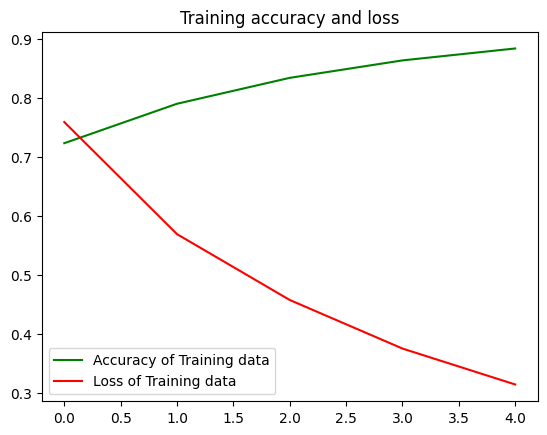

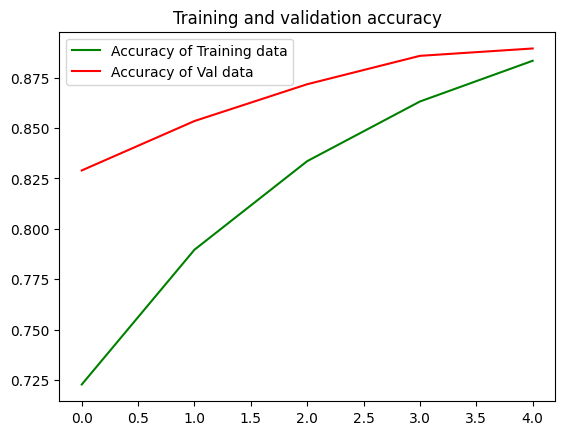

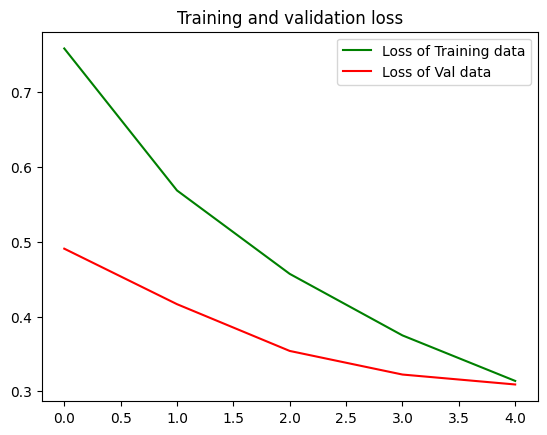

<Figure size 640x480 with 0 Axes>

In [27]:
get_ac=history.history['accuracy']
get_los=history.history['loss']
val_acc=history.history['val_accuracy']
val_loss=history.history['val_loss']

epochs=range(len(get_ac))
plt.plot(epochs,get_ac,'g',label='Accuracy of Training data')
plt.plot(epochs,get_los,'r',label='Loss of Training data')
plt.title('Training accuracy and loss')
plt.legend(loc=0)
plt.figure()

plt.plot(epochs,get_ac,'g',label='Accuracy of Training data')
plt.plot(epochs,val_acc,'r',label='Accuracy of Val data')
plt.title('Training and validation accuracy')
plt.legend(loc=0)
plt.figure()

epochs=range(len(get_ac))
plt.plot(epochs,get_los,'g',label='Loss of Training data')
plt.plot(epochs,val_loss,'r',label='Loss of Val data')
plt.title('Training and validation loss')
plt.legend(loc=0)
plt.figure()
plt.show()

In [28]:
model.evaluate(val_ds)

60/60 ━━━━━━━━━━━━━━━━━━━━ 10s 157ms/step - accuracy: 0.8846 - loss: 0.3161


[0.3091075122356415, 0.8894681930541992]

60/60 ━━━━━━━━━━━━━━━━━━━━ 10s 161ms/step - accuracy: 0.8935 - loss: 0.2851
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
0.3091074824333191 0.8894681930541992


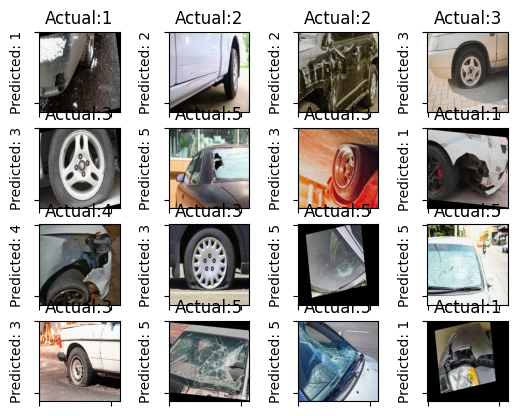

In [29]:
loss, accuracy=model.evaluate(val_ds)

class_names = [1, 2, 3, 4, 5, 6]
for images,labels in val_ds.take(1):
    for i in range(16):
        ax=plt.subplot(4,4,i+1)
        plt.imshow(images[i].numpy().astype('uint8'))
        predictions=model.predict(tf.expand_dims(images[i],0))
        score=tf.nn.softmax(predictions[0])
        if(class_names[labels[i]==class_names[np.argmax(score)]]):
            plt.title("Actual:" +str(class_names[labels[i]]))
            plt.ylabel('Predicted: '+str(class_names[np.argmax(score)]))
        else:
            plt.title("Actual:" +str(class_names[labels[i]]))
            plt.ylabel('Predicted: '+str(class_names[np.argmax(score)]))
        plt.gca().axes.yaxis.set_ticklabels([])
        plt.gca().axes.xaxis.set_ticklabels([])
print (loss, accuracy)

In [32]:
csv_test=pd.read_csv('/kaggle/working/test_ds/test.csv')
with tf.device(device_name):
    def predict(name):
        img=Image.open('/kaggle/working/test_ds/images/'+name)
        img=img.resize((224,224))
        arr=np.asarray(img)
        predictions=model.predict(tf.expand_dims(img,0))
        score=tf.nn.softmax(predictions[0])
        cls=class_names[np.argmax(score)]
        return(cls)
csv_test['predicted_label']=csv_test.filename.apply(predict)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 499ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━

In [33]:
print(sklearn.metrics.classification_report(csv_test.iloc[:,-2].values,csv_test.iloc[:,-1].values,\
                                           target_names=['Crack','Scratch','Flat tire','Dent','Glass shatter','Lamp broken']))

               precision    recall  f1-score   support

        Crack       0.66      0.80      0.72        55
      Scratch       0.89      0.71      0.79       782
    Flat tire       0.96      0.94      0.95       177
         Dent       0.72      0.86      0.79       670
Glass shatter       0.99      0.97      0.98       390
  Lamp broken       0.72      0.80      0.76       302

     accuracy                           0.83      2376
    macro avg       0.82      0.85      0.83      2376
 weighted avg       0.84      0.83      0.83      2376

